In [ ]:
import os
from dotenv import load_dotenv
from huggingface_hub import login
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import PyPDFLoader
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS
from langchain.chains import RetrievalQA
from langchain_huggingface import HuggingFaceEmbeddings, HuggingFaceEndpoint, ChatHuggingFace
from langchain.prompts import PromptTemplate
from langchain_core.documents import Document
from langchain_core.messages import HumanMessage
from langchain_core.tools import tool
from langgraph.graph import START, StateGraph, MessagesState
from langgraph.checkpoint.memory import MemorySaver
from typing_extensions import List, TypedDict
from IPython.display import Image, display
from langchain.tools.retriever import create_retriever_tool
from pydantic import BaseModel, Field
from typing import Literal
from langchain_core.messages import convert_to_messages
from langgraph.checkpoint.memory import MemorySaver


In [11]:
# === Load environment variables and login ===
load_dotenv()
hf_token = os.getenv("HUGGINGFACE_ACCESS_TOKEN")
# login(token=hf_token)

In [9]:
# === Load PDFs ===
directory_path = "../data"
all_docs = []

for file in os.listdir(directory_path):
    if file.endswith(".pdf"):
        file_path = os.path.join(directory_path, file)
        loader = PyPDFLoader(file_path)
        docs = loader.load()
        all_docs.extend(docs)

In [10]:
# === Text splitting ===
text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
texts = [doc.page_content for doc in all_docs]
chunks = [chunk for text in texts for chunk in text_splitter.split_text(text)]

print(f"Total chunks created: {len(chunks)}")

Total chunks created: 1694


In [14]:
# === Embedding and FAISS vector store ===
embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
vectorstore = FAISS.from_texts(chunks, embedding_model)
vectorstore.save_local("my_faiss_index")
print("Saved to vector store")

retriever = vectorstore.as_retriever()

retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_docs",
    "Search and return information from Suprema Biostar2 documentation.",
)

2025-06-04 08:45:14.446412: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749026714.475574   29110 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749026714.484117   29110 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.11/dist-package

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.11/dist-package

AttributeError: _ARRAY_API not found

Saved to vector store


In [15]:
# === LLM endpoint ===
hf_endpoint = HuggingFaceEndpoint(
    repo_id="meta-llama/Llama-4-Maverick-17B-128E-Instruct",
    task="text-generation",
    max_new_tokens=512,
    do_sample=False,
    repetition_penalty=1.03,
    api_key=hf_token,
)

response_model = ChatHuggingFace(llm=hf_endpoint, verbose=True, temperature=0)


In [16]:
def generate_query_or_respond(state: MessagesState):
    response = response_model.bind_tools(
        tools=[retriever_tool]
    ).invoke(state["messages"])

    return {"messages" : [response]}

input = {"messages": [{"role": "user", "content": "hello!"}]}
generate_query_or_respond(input)["messages"][-1].pretty_print()



================================== Ai Message ==================================

Hello! How can I assist you today?


In [17]:
input = {
    "messages": [
        {
            "role": "user",
            "content": "What does the docs say about creating a new user? please explain it in detail",
        }
    ]
}
generate_query_or_respond(input)["messages"][-1].pretty_print()

================================== Ai Message ==================================

[retrieve_docs(query="creating a new user")] 
 
I can help with that. To provide a detailed explanation, I'll need to look up the information in the Suprema Biostar2 documentation.

[retrieve_docs(query="Biostar2 create new user")]


In [22]:
GRADE_PROMPT = (
    "You are a grader assessing relevance of a retrieved document to a user question. \n "
    "Here is the retrieved document: \n\n {context} \n\n"
    "Here is the user question: {question} \n"
    "If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n"
    "Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."
)


class GradeDocuments(BaseModel):
    """Grade documents using a binary score for relevance check."""

    binary_score: str = Field(
        description="Relevance score: 'yes' if relevant, or 'no' if not relevant"
    )


grader_model = ChatHuggingFace(llm=hf_endpoint, verbose=True, temperature=0)

def grade_documents(
    state: MessagesState,
) -> Literal["generate_answer", "rewrite_question"]:
    """Determine whether the retrieved documents are relevant to the question."""
    question = state["messages"][0].content
    context = state["messages"][-1].content

    prompt = GRADE_PROMPT.format(question=question, context=context)
    response = grader_model.invoke(
        [{"role": "user", "content": prompt}]
    )

    answer = response.content.strip().lower()

    # crude check for binary response
    if "yes" in answer:
        return "generate_answer"
    else:
        return "rewrite_question"

In [23]:


input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "What does Lilian Weng say about types of reward hacking?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_blog_posts",
                        "args": {"query": "types of reward hacking"},
                    }
                ],
            },
            {"role": "tool", "content": "meow", "tool_call_id": "1"},
        ]
    )
}
grade_documents(input)

'rewrite_question'

In [26]:
input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "What does the documentation say about Adding a new user?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_docs",
                        "args": {"query": "types of reward hacking"},
                    }
                ],
            },
            {
                "role": "tool",
                "content": "reward hacking can be categorized into two types: environment or goal misspecification, and reward tampering",
                "tool_call_id": "1",
            },
        ]
    )
}
grade_documents(input)

'rewrite_question'

In [27]:
REWRITE_PROMPT = (
    "Look at the input and try to reason about the underlying semantic intent / meaning.\n"
    "Here is the initial question:"
    "\n ------- \n"
    "{question}"
    "\n ------- \n"
    "Formulate an improved question:"
)


def rewrite_question(state: MessagesState):
    """Rewrite the original user question."""
    messages = state["messages"]
    question = messages[0].content
    prompt = REWRITE_PROMPT.format(question=question)
    response = response_model.invoke([{"role": "user", "content": prompt}])
    return {"messages": [{"role": "user", "content": response.content}]}

In [29]:
input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "What are the components present in biostar2?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_docs",
                        "args": {"query": "types of reward hacking"},
                    }
                ],
            },
            {"role": "tool", "content": "meow", "tool_call_id": "1"},
        ]
    )
}

response = rewrite_question(input)
print(response["messages"][-1]["content"])

To improve the question "What are the components present in biostar2?", let's first understand what Biostar2 is. Biostar2 is likely referring to a product, system, or platform related to biotechnology or a specific technical field. The question seems to be inquiring about the parts or elements that make up Biostar2.

### Reasoning about the Semantic Intent

1. **Understanding Biostar2**: The first step is to identify what Biostar2 refers to. It could be a product, a software platform, a biological product, or a system used in biotechnological research or applications. Without specific context, we assume it's a complex entity with multiple parts.

2. **Identifying "Components"**: The term "components" is broad and can refer to anything from physical parts, software modules, functional elements, to conceptual parts of a system. The intent here seems to be to understand the makeup or the structure of Biostar2.

3. **Semantic Intent**: The underlying intent is to gain a deeper understandin

In [30]:
GENERATE_PROMPT = (
    "You are an assistant for question-answering tasks. "
    "Use the following pieces of retrieved context to answer the question. "
    "If you don't know the answer, just say that you don't know. "
    "Use three sentences maximum and keep the answer concise.\n"
    "Question: {question} \n"
    "Context: {context}"
)


def generate_answer(state: MessagesState):
    """Generate an answer."""
    question = state["messages"][0].content
    context = state["messages"][-1].content
    prompt = GENERATE_PROMPT.format(question=question, context=context)
    response = response_model.invoke([{"role": "user", "content": prompt}])
    return {"messages": [response]}

In [31]:
input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "What does Lilian Weng say about types of reward hacking?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_blog_posts",
                        "args": {"query": "types of reward hacking"},
                    }
                ],
            },
            {
                "role": "tool",
                "content": "reward hacking can be categorized into two types: environment or goal misspecification, and reward tampering",
                "tool_call_id": "1",
            },
        ]
    )
}

response = generate_answer(input)
response["messages"][-1].pretty_print()

================================== Ai Message ==================================

Lilian Weng categorizes reward hacking into two types. These types are environment or goal misspecification and reward tampering. This indicates that reward hacking can occur due to issues with the environment or goal setup, or due to manipulation of the reward itself.


In [35]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

workflow = StateGraph(MessagesState)

memory = MemorySaver()

# Define the nodes we will cycle between
workflow.add_node(generate_query_or_respond)
workflow.add_node("retrieve", ToolNode([retriever_tool]))
workflow.add_node(rewrite_question)
workflow.add_node(generate_answer)

workflow.add_edge(START, "generate_query_or_respond")

# Decide whether to retrieve
workflow.add_conditional_edges(
    "generate_query_or_respond",
    # Assess LLM decision (call `retriever_tool` tool or respond to the user)
    tools_condition,
    {
        # Translate the condition outputs to nodes in our graph
        "tools": "retrieve",
        END: END,
    },
)

# Edges taken after the `action` node is called.
workflow.add_conditional_edges(
    "retrieve",
    # Assess agent decision
    grade_documents,
)
workflow.add_edge("generate_answer", END)
workflow.add_edge("rewrite_question", "generate_query_or_respond")

# Compile
graph = workflow.compile(checkpointer=memory)

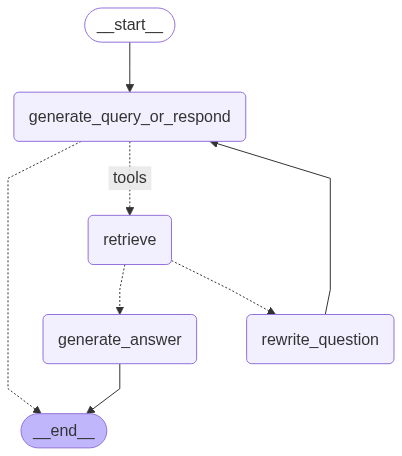

In [36]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [40]:
for chunk in graph.stream(
    input = {
        "messages": [
            {
                "role": "user",
                "content": "What is the frequency that needs to be set in the camera?",
            }
        ]
    },
    config = {
        "thread_id" : "thread-001"
    }
):
    for node, update in chunk.items():
        print("Update from node", node)
        update["messages"][-1].pretty_print()
        print("\n\n")

Update from node generate_query_or_respond
================================== Ai Message ==================================
Tool Calls:
  retrieve_docs (call_6YiszlQUFkLQ78Co3NYdW0A4)
 Call ID: call_6YiszlQUFkLQ78Co3NYdW0A4
  Args:
    query: camera frequency setting



Update from node retrieve
================================= Tool Message =================================
Name: retrieve_docs

28
Device
Device
Camera
Set the frequency to prevent the video from flickering.
1 Press 
  and authenticate with the Admin level credential.
2 Select DEVICE → Camera.
• Power Line Frequency: Set the frequency to 50 Hz or 60 Hz to prevent the video from flickering, depending on 
the lighting conditions where the device is installed.

28
Device
Device
Camera
Set the frequency to prevent the video from flickering.
1 Press 
  and authenticate with the Admin level credential.
2 Select DEVICE → Camera.
• Power Line Frequency: Set the frequency to 50 Hz or 60 Hz to prevent the video from flickering, d

In [41]:
for chunk in graph.stream(
    input = {
        "messages": [
            {
                "role": "user",
                "content": "Hello, My name is AJ, what is your name?",
            }
        ]
    },
    config = {
        "thread_id" : "thread-001"
    }
):
    for node, update in chunk.items():
        print("Update from node", node)
        update["messages"][-1].pretty_print()
        print("\n\n")

Update from node generate_query_or_respond
================================== Ai Message ==================================

Hello AJ, I'm an AI assistant. I don't have a personal name, but I'm here to help you with any questions or tasks you have.





In [42]:
for chunk in graph.stream(
    input = {
        "messages": [
            {
                "role": "user",
                "content": "Hi, what is my name?",
            }
        ]
    },
    config = {
        "thread_id" : "thread-001"
    }
):
    for node, update in chunk.items():
        print("Update from node", node)
        update["messages"][-1].pretty_print()
        print("\n\n")

Update from node generate_query_or_respond
================================== Ai Message ==================================

Your name is AJ. You mentioned it earlier in our conversation.



